# Rozpoznanie czerniaka na obrazku za pomocą prostej sieci konwolucyjnej

Zaczynamy od wstępnego przetwarzania danych danych treningowych i testowych za pomocą klasy `ImageDataGenerator`.
Za jej pomocą osiągamy kilku celów:
- zwiększamy ilość danych testowych, ponieważ `ImageDataGenerator` tworzy nowe obrazy ze starych, stosując transformacji (skalowanie, horyzontalne obracanie, itd).
- formatowanie obrazów do konwolucji

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('training_gallery',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 7941 images belonging to 2 classes.


In [3]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('testing_gallery',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1984 images belonging to 2 classes.


Budujemy sieć konwolucyjną z 3 warstwami konwolucyjnymi (ang. convolutional layer) i 2 warstwami gęstymi (ang. dense layer).

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

Tworzymy strategiję obliczeniową.

In [5]:
cnn = Sequential([
    # pierwsza warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D(pool_size=2, strides=2),

    # druga warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    # trzecia warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    # wyprostowanie
    Flatten(),

    # 2 warstwy gęste
    Dense(units=128, activation='relu'),
    Dense(units=128, activation='relu'),

    # warstwa wyjściowa
    Dense(units=1, activation='sigmoid')
])

Kompilujemy poprzednio zbudowany model.

In [6]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Trenujemy sieć konwolucyjną.

In [7]:
history = cnn.fit(x=training_set, validation_data=test_set, epochs=25)

Epoch 1/25
249/249 [==============================] - 1110s 4s/step - loss: 0.1898 - accuracy: 0.9593 - val_loss: 0.0586 - val_accuracy: 0.9884
Epoch 2/25
249/249 [==============================] - 998s 4s/step - loss: 0.0769 - accuracy: 0.9786 - val_loss: 0.0509 - val_accuracy: 0.9889
Epoch 3/25
249/249 [==============================] - 995s 4s/step - loss: 0.0801 - accuracy: 0.9749 - val_loss: 0.0591 - val_accuracy: 0.9889
Epoch 4/25
249/249 [==============================] - 994s 4s/step - loss: 0.0756 - accuracy: 0.9772 - val_loss: 0.0472 - val_accuracy: 0.9884
Epoch 5/25
249/249 [==============================] - 994s 4s/step - loss: 0.0773 - accuracy: 0.9748 - val_loss: 0.0493 - val_accuracy: 0.9884
Epoch 6/25
249/249 [==============================] - 993s 4s/step - loss: 0.0640 - accuracy: 0.9732 - val_loss: 0.1150 - val_accuracy: 0.9884
Epoch 7/25
249/249 [==============================] - 993s 4s/step - loss: 0.0698 - accuracy: 0.9760 - val_loss: 0.0412 - val_accuracy: 0.988

Historia trenowania modelu.

In [8]:
import matplotlib.pyplot as plt

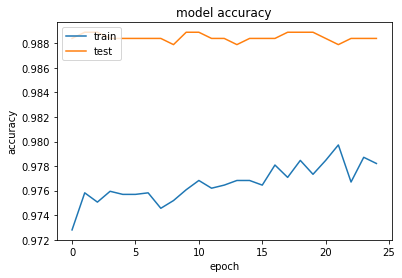

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

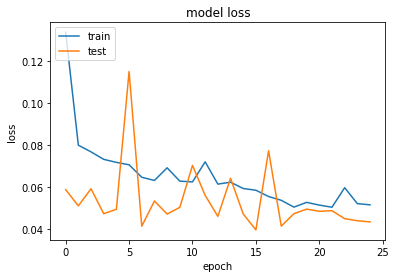

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Zapisujemy model.

In [11]:
cnn_json_structure = cnn.to_json()
with open("simple_cnn.json", "w") as json_file:
    json_file.write(cnn_json_structure)
cnn.save_weights("simple_cnn.h5")

Ładujemy model, żeby sprawdzić czy poprawnie zapisaliśmy go.

In [12]:
from tensorflow.keras.models import model_from_json

In [13]:
json_file = open('simple_cnn.json', 'r')
cnn_json_structure = json_file.read()
json_file.close()
cnn = model_from_json(cnn_json_structure)
cnn.load_weights("simple_cnn.h5")

Robimy kilka testowych pojedynczych.
1) dla czerniaka niezłośliwego

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [22]:
test_image = image.load_img('single_prediction_gallery/benign.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image *= (1/255.0)
result = cnn.predict(test_image)

In [23]:
training_set.class_indices

{'benign': 0, 'malignant': 1}

In [24]:
result

array([[0.]], dtype=float32)

2) dla czerniaka złośliwego

In [25]:
test_image = image.load_img('single_prediction_gallery/malignant.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image *= (1/255.0)
result = cnn.predict(test_image)

In [26]:
result

array([[0.00085427]], dtype=float32)